In [39]:
#%matplotlib inline
# import dependencies
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [40]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [41]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# set a variable to connect to the engine
conn = engine.connect()

# reflect an existing database into a new model 
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found by calling the keys function
# to display the titles of the keys
Base.classes.keys()

C:\Users\thegr\AppData\Local\Temp\ipykernel_62396\1632975285.py:11: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


['measurement', 'station']

In [42]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create a session (link) from Python to the DB
Session = Session(engine)

# Exploratory Precipitation Analysis

In [43]:
# Find the most recent date in the data set
most_recent = Session.query(func.max(Measurement.date)).scalar()

# convert date column to date format
most_recent = datetime.strptime(most_recent, "%Y-%m-%d")

# display the result
print(f"The most recent date of measurement is: {most_recent}")

The most recent date of measurement is: 2017-08-23 00:00:00


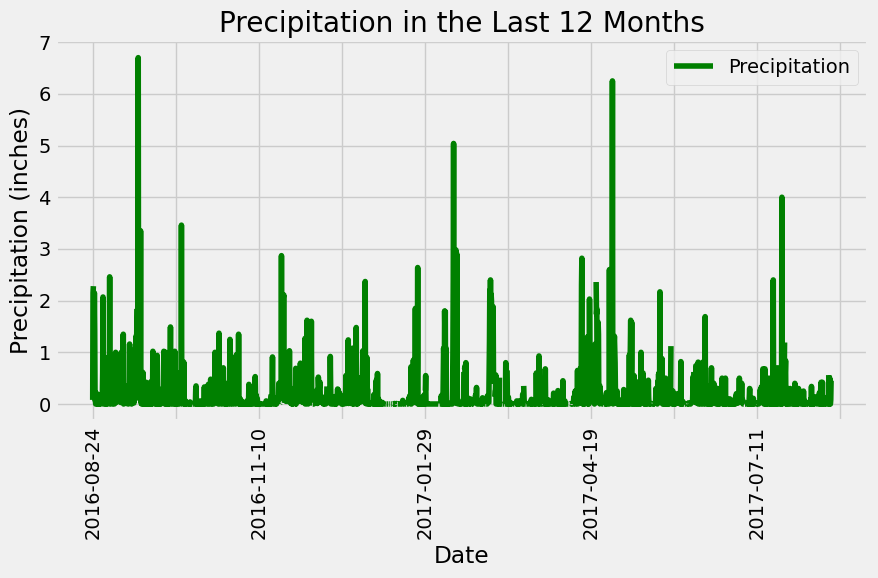

In [62]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
prcps = Session.query(Measurement).all()

# Calculate the date one year from the last date in data set.
twelve_months_prior = most_recent - timedelta(days=365)

# Perform a query to retrieve the last 12 months of precipitation data
# Only retrieve the 'date' and 'prcp' columns
twelve_month_prcp = (
    Session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= twelve_months_prior)
    .order_by(Measurement.date)
    .all()
)

# Step 4: Save the query results as a Pandas DataFrame with explicit column names
# Exclude the 'id' column and only include 'date' and 'prcp'
prcp_df = pd.DataFrame(twelve_month_prcp, columns=['date', 'prcp'])

# ensure that the index for the dataframe is set to the dates
prcp_df.set_index('date', inplace=True)

# Plot the data
ax = prcp_df.plot(figsize=(9, 6), rot=90, color='green')  # Set the figure size and rotate x-axis labels
ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
plt.title('Precipitation in the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.grid(True)
ax.legend(['Precipitation'], loc='upper right')
plt.tight_layout()
plt.show()


In [45]:
# Use Pandas to calculate the summary statistics for the precipitation data
print("The summary statistics of this dataset are below:")
prcp_df.describe()

The summary statistics of this dataset are below:


,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [46]:
# Design a query to calculate the total number of stations in the dataset
stations = (
    Session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs)
    .order_by(Measurement.date)
    .all()
)

# Create a dataframe from this query data
stations_df = pd.DataFrame(stations, columns=['station', 'date', 'prcp','tobs'])

# get the total number of unique station numbers and print them
print(f"The total number of stations in this dataset is: {len(stations_df.station.unique())}")


The total number of stations in this dataset is: 9


In [ ]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
print("The number of precipitation measurements for each \nstation in this dataset are below in descending order:")
print("*************************************************")
print(stations_df['station'].value_counts().reset_index())  # create a dataframe of this data for better-formatted viewing
print("\n***********************************************")


The number of precipitation measurements for each 
station in this dataset are below in descending order:
*************************************************
       station  count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511

***********************************************


In [53]:
# capture the most active station ID from the previous query into a variable
most_active_station_id = stations_df['station'].mode()[0]

# Using this most active station ID, calculate the lowest, highest, and average temperature.
# create a dataframe of all the rows for the most active station captured from the code above
most_active_station_data = stations_df[stations_df['station'] == most_active_station_id]

# print the calculations to terminal
print(f"The most active station with the most readings was: {most_active_station_id}")
print(f"The lowest temperature recorded at the most active station was: {most_active_station_data['tobs'].min()}°F")
print(f"The highest temperature recorded at the most active station was: {most_active_station_data['tobs'].max()}°F")
print(f"The average temperature recorded at the most active station was: {most_active_station_data['tobs'].mean().round(2)}°F")


The most active station with the most readings was: USC00519281
The lowest temperature recorded at the most active station was: 54.0°F
The highest temperature recorded at the most active station was: 85.0°F
The average temperature recorded at the most active station was: 71.66°F


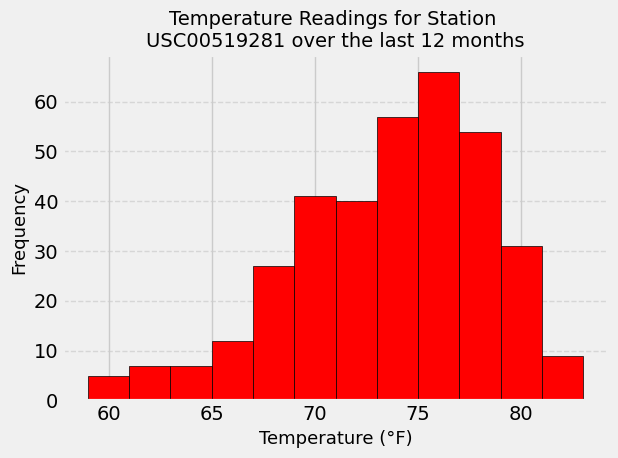

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# since I already captured this data for the most active station in a dataframe, I can calculate from there
# rather than using resources to re-query the data

# convert the most recent date found into a datetime format so I can calculate 12 months prior
most_recent_date = pd.to_datetime(most_active_station_data['date'].max())

# subtracting 12 months (365 days) from the most recent date to find 12 months prior
twelve_months_ago = pd.to_datetime(most_recent_date - timedelta(days=365))

# filter the dataframe to only display only the last 12 months of data
most_active_station_data_twelve_months = most_active_station_data[pd.to_datetime(most_active_station_data['date']) > twelve_months_ago]

# plot the histogram figure
plt.hist(most_active_station_data_twelve_months['tobs'], bins=12, color='red', edgecolor='black')
plt.title(f'Temperature Readings for Station \n{most_active_station_id} over the last 12 months', fontsize=14)
plt.xlabel('Temperature (°F)', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Optional: add gridlines for clarity
plt.tight_layout()
plt.show()

# Close Session

In [51]:
# Close Session
Session.close()